# RNN on Time Series


In [2]:
# Imports
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
# Plotting datetime values with matplotlib
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

# Settings
register_matplotlib_converters()
# This solves the crashing issue of matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Reading data

In [3]:
# Reading the data and convert to dataframe
df = pd.read_csv('../Course Resources/Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
# Checking las values
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [5]:
# Check data of our datframe
len(df)

325

In [6]:
# Deleting na values
df = df.dropna()

# Check if we shrink the df
len(df)

325

<AxesSubplot:xlabel='DATE'>

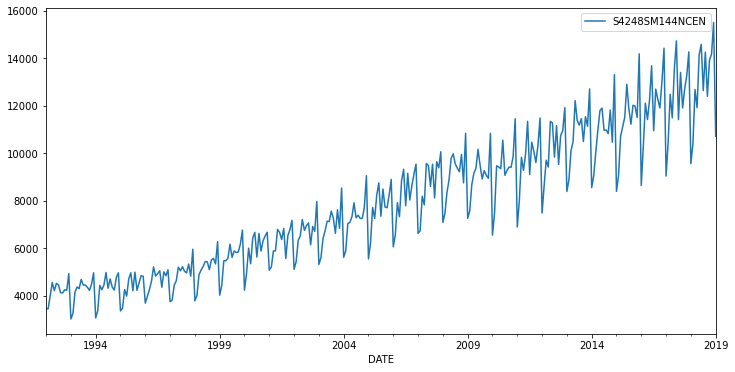

In [7]:
# Plot the values of the df
df.plot(figsize=(12, 6))

The plot shows a increasing buy of alcohol with seasonal ups and downs. This could be caused for holidays like 4th july or Christmas.


In [8]:
# Let's check the type of the data
df.columns

Index(['S4248SM144NCEN'], dtype='object')

The datatype is object, basically threatened as strings.
More processing must be done to the data to be used like floats

In [10]:
# creating a new array with the data as float
y = df['S4248SM144NCEN'].values.astype('float')
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

## Setting the test and train data

We will use the last year as the test data and the years before as the training set.

In [15]:
# Setting train and test sets
test_size = 12 # The last 12 months
# Creating test and training set
train_set = y[:-test_size] # All but last 12 months
test_set = y[-test_size:] # The last 12 months

The range of our data is very spread, this will struggle the RNN. The recommended solution is to normalize all data. This will help the neurons to learn better, faster and be more accurate.

**Sklearn** has an special scaler to do this for us!

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))

A possible problem is leaking the future values that will be bigger than the max actual value, we must take care of this.

In [16]:
# Let's fit our scaler with our actual data.
scaler.fit(train_set.reshape(-1, 1)) # Setting the shape of the training set.set.add

# Train normalization
train_norm = scaler.transform((train_set.reshape(-1, 1)))
train_norm

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381],
       [-0.74390974],
       [-0.75467989],
       [-0.81092401],
       [-0.81280451],
       [-0.79006753],
       [-0.79331567],
       [-0.67433114],
       [-1.        ],
       [-0.9606804 ],
       [-0.80699205],
       [-0.76989486],
       [-0.7818617 ],
       [-0.71536029],
       [-0.75604753],
       [-0.75621848],
       [-0.77211727],
       [-0.79399949],
       [-0.74886742],
       [-0.66783486],
       [-0.99247799],
       [-0.94084965],
       [-0.75861185],
       [-0.78972562],
       [-0.75570562],
       [-0.66595436],
       [-0.77895547],
       [-0.71142833],
       [-0.77040773],
       [-0.79194803],
       [-0.70031627],
       [-0.66834772],
       [-0.94204633],
       [-0.92255748],
       [-0.78835798],
       [-0.83537054],
       [-0.71211215],
       [-0.66783486],
       [-0.7962219 ],
       [-0.66339003],
       [-0.79417044],
       [-0

In [18]:
# Convert to Tensor
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [19]:
# Setting the window size (The 12 months to predict)
window_size = 12

In [20]:
# Creation of a function to create batches for our sequence data
def input_data(seq, ws):
    out = []
    L = len(seq)

    # Creating batch tuple
    for i in range(L-ws):
        window = seq[i:i+ws] # [1, 2, 3]
        label = seq[i+ws:i+ws+1] # [4]
        out.append((window, label))

    return out

In [22]:
train_data = input_data(train_norm, window_size)
train_data

[(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
          -0.8128, -0.7901, -0.7933, -0.6743]),
  tensor([-1.])),
 (tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
          -0.7901, -0.7933, -0.6743, -1.0000]),
  tensor([-0.9607])),
 (tensor([-0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128, -0.7901,
          -0.7933, -0.6743, -1.0000, -0.9607]),
  tensor([-0.8070])),
 (tensor([-0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128, -0.7901, -0.7933,
          -0.6743, -1.0000, -0.9607, -0.8070]),
  tensor([-0.7699])),
 (tensor([-0.7966, -0.7439, -0.7547, -0.8109, -0.8128, -0.7901, -0.7933, -0.6743,
          -1.0000, -0.9607, -0.8070, -0.7699]),
  tensor([-0.7819])),
 (tensor([-0.7439, -0.7547, -0.8109, -0.8128, -0.7901, -0.7933, -0.6743, -1.0000,
          -0.9607, -0.8070, -0.7699, -0.7819]),
  tensor([-0.7154])),
 (tensor([-0.7547, -0.8109, -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607,
          

In [23]:
# Checking the size of our data
print(f"len of original data: {len(y)}")
print(f"len of train data: {len(train_data)}")

len of original data: 325
len of train data: 301


In [24]:
# Let's see a part of our data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

---------------

# Defining the model

In [25]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)

        # FC layer
        self.linear = nn.Linear(hidden_size, output_size)

        # Init h0 and c0 (this is from the LSTM cell)
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1),
                                          self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))

        # We just want the last value
        return pred[-1]

In [26]:
# Setting manual seed
torch.manual_seed(101)

# Instanciate
model = LSTMnetwork()

# Setting criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Show model
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
# Show number of params
total = 0
for param in model.parameters():
    print(param.numel())
    total += param.numel()
print(''.center(40, '='))
print(f"Total param: {total}")

400
40000
400
400
100
1
Total param: 41301


# Training

In [29]:
# Setting training configs
epochs = 100
toc = time()

# Main loop
for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()

        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        # Make a prediction and updating layers
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss {loss.item()}")

# Printing final time
tic = time()
total_time = tic - toc
print(f"Total time: {total_time} segs")
print(f"Total time: {total_time / 60} min")

Epoch 0 Loss 0.2531020939350128
Epoch 1 Loss 0.3753201365470886
Epoch 2 Loss 0.390271931886673
Epoch 3 Loss 0.34934696555137634
Epoch 4 Loss 0.33085644245147705
Epoch 5 Loss 0.3322998285293579
Epoch 6 Loss 0.3267034888267517
Epoch 7 Loss 0.32074129581451416
Epoch 8 Loss 0.3065353333950043
Epoch 9 Loss 0.29518038034439087
Epoch 10 Loss 0.2693434953689575
Epoch 11 Loss 0.25998514890670776
Epoch 12 Loss 0.24665714800357819
Epoch 13 Loss 0.22403818368911743
Epoch 14 Loss 0.18602792918682098
Epoch 15 Loss 0.18561148643493652
Epoch 16 Loss 0.17209382355213165
Epoch 17 Loss 0.25162333250045776
Epoch 18 Loss 0.22557726502418518
Epoch 19 Loss 0.17450936138629913
Epoch 20 Loss 0.2023782581090927
Epoch 21 Loss 0.20813527703285217
Epoch 22 Loss 0.16641975939273834
Epoch 23 Loss 0.17605148255825043
Epoch 24 Loss 0.11976473033428192
Epoch 25 Loss 0.0964580550789833
Epoch 26 Loss 0.045710522681474686
Epoch 27 Loss 0.05649115517735481
Epoch 28 Loss 0.001215607626363635
Epoch 29 Loss 0.114146389067173


As the data is normalized is pretty normal have little loss values.

# Comparing results of the model vs actual data

In [30]:
# Setting how much we will look into future
future = 12

preds = train_norm[-window_size:].tolist()

# Setting model into evaluation mode
model.eval()

for i in range(future):
    # Getting the sequence
    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        preds.append(model(seq).item())

# Checking predicted values
preds[window_size:]

[0.24252602458000183,
 0.6267620921134949,
 0.43970999121665955,
 0.8351505994796753,
 1.0259838104248047,
 0.44212213158607483,
 0.7402645945549011,
 0.5118022561073303,
 0.6928802728652954,
 0.7601770162582397,
 0.8815797567367554,
 0.16979515552520752]

This data is not very understandable for humans, so we need to un-transform it.

## Returning data to current values

In [32]:
# Returning data to correct values
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

true_predictions

array([[10299.15598078],
       [12546.74485782],
       [11452.58359362],
       [13765.71343166],
       [14881.99229908],
       [11466.69340871],
       [13210.67774585],
       [11874.2872971 ],
       [12933.50315613],
       [13327.1554566 ],
       [14037.30078703],
       [ 9873.71676224]])

In [33]:
# Let's check the last values
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

# Plotting results

In [34]:
# Generating the dates for our data
# We're going 1 month to future as it is not inclusive.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [35]:
# Let's check if are similar.
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

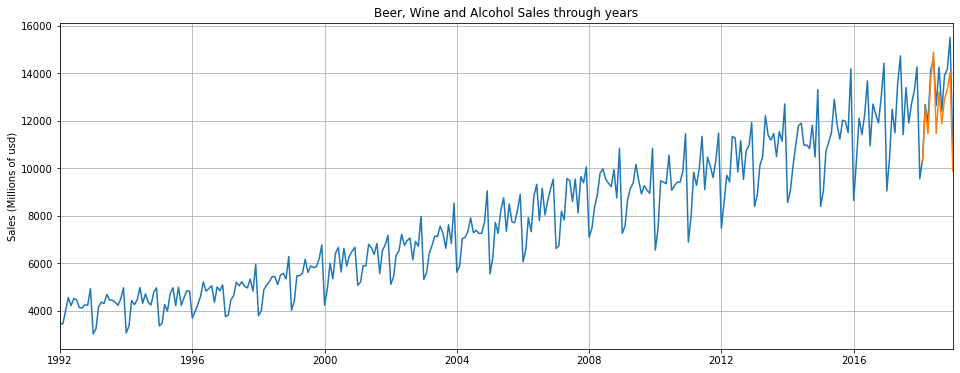

In [37]:
# Matplotlib plot
plt.figure(figsize=(16, 6))
plt.title('Beer, Wine and Alcohol Sales through years')
plt.ylabel('Sales (Millions of usd)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions)
plt.show()

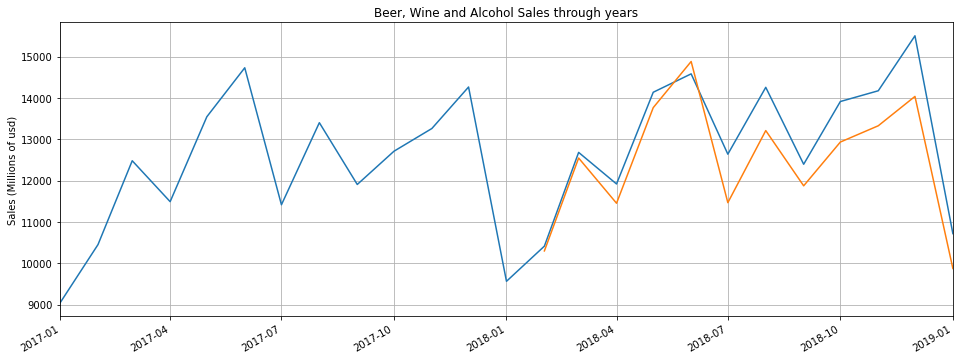

In [40]:
# Matplotlib zoom
fig = plt.figure(figsize=(16, 6))
plt.title('Beer, Wine and Alcohol Sales through years')
plt.ylabel('Sales (Millions of usd)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_predictions)
plt.show()

In [ ]:
# Plotly plots

# Forecasting unknown future

## Training with all data

In [41]:
# Setting training configs
epochs = 100

# Setting model to training mode (it was on evaluation mode)
model.train()

# Feature scaling all the dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size) # Our function to get batches

# Init time
toc = time()

# Main loop
for epoch in range(epochs):
    for seq, y_train in all_data:
        optimizer.zero_grad()

        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        # Make a prediction and updating layers
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1:2} Loss {loss.item():10.8f}")

# Printing final time
tic = time()
total_time = tic - toc
print(f"Total time: {total_time:.2f} segs")
print(f"Total time: {total_time / 60} min")

Epoch  1 Loss 0.01941586
Epoch  2 Loss 0.02900102
Epoch  3 Loss 0.01772452
Epoch  4 Loss 0.01616115
Epoch  5 Loss 0.01492068
Epoch  6 Loss 0.01446190
Epoch  7 Loss 0.01382533
Epoch  8 Loss 0.01423280
Epoch  9 Loss 0.01357602
Epoch 10 Loss 0.00958912
Epoch 11 Loss 0.00745150
Epoch 12 Loss 0.00601862
Epoch 13 Loss 0.00586351
Epoch 14 Loss 0.00466521
Epoch 15 Loss 0.00558394
Epoch 16 Loss 0.00504329
Epoch 17 Loss 0.00607216
Epoch 18 Loss 0.00223212
Epoch 19 Loss 0.00506671
Epoch 20 Loss 0.00544172
Epoch 21 Loss 0.00647368
Epoch 22 Loss 0.00358336
Epoch 23 Loss 0.00321669
Epoch 24 Loss 0.00202412
Epoch 25 Loss 0.00218441
Epoch 26 Loss 0.00698097
Epoch 27 Loss 0.00115116
Epoch 28 Loss 0.00143223
Epoch 29 Loss 0.00110073
Epoch 30 Loss 0.00061020
Epoch 31 Loss 0.00074808
Epoch 32 Loss 0.00154954
Epoch 33 Loss 0.00008056
Epoch 34 Loss 0.00119266
Epoch 35 Loss 0.00378208
Epoch 36 Loss 0.00003746
Epoch 37 Loss 0.00257914
Epoch 38 Loss 0.00007931
Epoch 39 Loss 0.00049600
Epoch 40 Loss 0.00002197


## Forecasting

For this data we cannot assure that the predictions will be true!

In [42]:
# Settings
window_size = 12
future = 12
L = len(y)

# Getting points to predict
preds = y_norm[-window_size:].tolist() # Last 12 points.

# Setting eval mode
model.eval()

for i in range(future):
    # Set sequence
    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        # Predicting and append the prediction.
        preds.append(model(seq).item())

# Gettin back to normal data
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

true_predictions

array([[10415.00001808],
       [12683.00013363],
       [11919.00006013],
       [14137.99993426],
       [14583.00009555],
       [12640.00017402],
       [14257.00005591],
       [12395.9999277 ],
       [13913.99994579],
       [14173.99995232],
       [15504.        ],
       [10717.99998423],
       [11504.31420684],
       [13090.40372071],
       [12917.85075638],
       [14404.73186907],
       [14026.81791949],
       [14024.2154772 ],
       [15157.48560771],
       [13905.81903592],
       [15303.30824453],
       [14814.61337078],
       [17432.2614221 ],
       [11796.24793857]])

## Plotting future

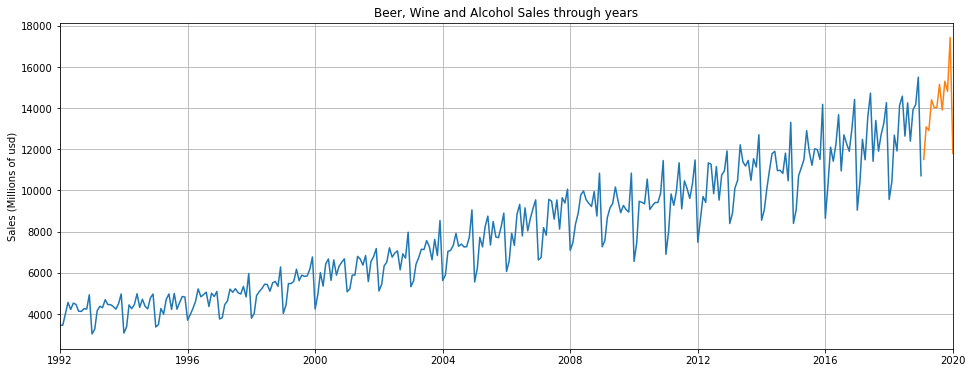

In [56]:
# Matplotlib plot
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[M]')

plt.figure(figsize=(16, 6))
plt.title('Beer, Wine and Alcohol Sales through years')
plt.ylabel('Sales (Millions of usd)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions[window_size:])
plt.show()

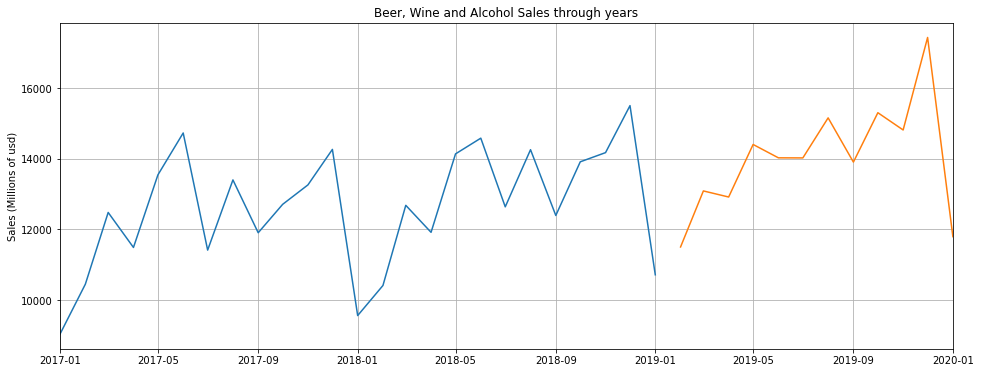

In [47]:
# Matplot zoom
plt.figure(figsize=(16, 6))
plt.title('Beer, Wine and Alcohol Sales through years')
plt.ylabel('Sales (Millions of usd)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_predictions[window_size:])
plt.show()